In [1]:
from utils.scenario_gen import *
from utils.trees import *
from utils.clustering import *
from utils.optimization import *
from utils.simulation import *

from pathlib import Path
import pickle
from pyomo.util.infeasible import log_infeasible_constraints
import logging

In [2]:
datapath = Path(Path().resolve()).parent.parent.parent / 'data'
scenario_path = datapath / 'forecast data' / 'Scenarios' 
market_datapath = datapath / 'market data'
wl_datapath = datapath / 'waterlevel data'
wb_datapath = datapath / 'waterboard data'
ark_datapath = datapath / 'ark data'

optimization_datapath = datapath / 'optimization data' / 'operational plots'
n_root_steps = 3
n_scenarios = 5

n_q_scenarios = n_scenarios
n_dam_scenarios = n_scenarios
n_idm_scenarios = n_scenarios
n_wl_scenarios = n_scenarios

if (n_q_scenarios <= 3):
    n_wb_scenarios = 3
else:
    n_wb_scenarios = n_q_scenarios

distance_metric = 'energy'
scenario_params = {
    'DAM': {
        'n': n_dam_scenarios,
        'method': distance_metric,
    },
    'IDM':{
        'n_init': 100,
        'n': n_idm_scenarios,
        'method': distance_metric,
    },
    'wl': {
        'n': n_wl_scenarios,
        'method': distance_metric,
    },
    'discharge': {
        'n': n_q_scenarios,
        'n_wb': n_wb_scenarios,
        'method': distance_metric
    },
    'n_root_steps': n_root_steps
}

In [3]:
obs_data = ObservationData(market_datapath, wl_datapath, wb_datapath, ark_datapath)
idm_scenarios = IDMScenarios(
    obs_dataclass=obs_data,
    n_init=scenario_params['IDM']['n_init'],
    n=scenario_params['IDM']['n'],
    method=scenario_params['IDM']['method'],
    cluster=True,
)
t_min = idm_scenarios.dam.index.min()
idm_scenarios.update_bn(t_min=t_min, t_max=t_min + pd.DateOffset(days=365))

scenario_data = ScenarioData(
    scenario_params=scenario_params,
    scenario_path=scenario_path,
    constrain_tree_complexity=True,
    complexity_reduction=0.5,
)

In [4]:
h_max = -0.4
optimization_settings = {
    'wl_constraint_type': 'robust',
    'var_wl': -0.4,
    'cvar_wl': -0.3,
    'cvar_alpha': 0.9,
    'p_chance': 1,
    'h_max': h_max,
    'obj_type': 'expected_value',
    'refit_idm_bn_every': 7*24, # every week
    'start_wl': -0.41, # m+NAP
    'distance': distance_metric,
    'n_scenarios': n_scenarios,
    'tree': True
}
if optimization_settings['tree']:
    tree_classes = ['discharge', 'wl']
else:
    tree_classes = []
# month = cfg.month

if h_max == -0.4:
    wl_type = 'low wl'
elif h_max == -0.3:
    wl_type = 'high wl'
else:
    raise ValueError('h_max should be -0.4 or -0.3')

In [5]:
exp_name = 'plotting'
optimization_datapath_exp = None

year = 2019
month = 1

t_now = obs_data.dam.loc[(obs_data.dam.index.year==year) & (obs_data.dam.index.month==month)].index.min() + pd.DateOffset(hours=11)
t_now = t_now + pd.DateOffset(days=16) - pd.DateOffset(hours=6)
t_now

Timestamp('2019-01-17 05:00:00+0100', tz='Europe/Amsterdam')

In [6]:
simulation_index = pd.date_range(t_now, t_now + pd.DateOffset(days=7), freq='H')

In [7]:

simulator = ClosedLoopSimulation(
    savepath=optimization_datapath / exp_name,
    optimization_settings=optimization_settings,
    simulation_index=simulation_index,
    observation_dataclass=obs_data,
    scenario_dataclass=scenario_data,
    idm_scenarioclass=idm_scenarios,
    save_individual_timesteps=True,
    simulation_data=None,
    tree_classes=tree_classes,
)

In [8]:
data_dict = simulator.prep_opt_data(t_now, inplace=True, return_data=True)

In [9]:
# data_dict['idm']

In [10]:
problem = NZKProblem(
    optimization_data=data_dict,
    optimization_settings=optimization_settings,
    tree_classes=tree_classes,
    pred_hor=48,
    logfile=str((simulator.savepath_timesteps / f'{t_now.strftime("%Y-%m-%d")}.log').resolve())
)

In [11]:
problem.make_model()

In [12]:
model = problem.solve(verbose=True)

Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2398474
Academic license 2398474 - for non-commercial use only - registered to t.___@tudelft.nl
Read LP format model from file C:\Users\Heijden\AppData\Local\Temp\tmpp4py6s17.pyomo.lp
Reading time = 0.01 seconds
x2374: 2379 rows, 2374 columns, 5429 nonzeros
Set parameter NonConvex to value 2
Set parameter MIPGap to value 0.01
Set parameter MIPGapAbs to value 9.1182638825567618e-03
Set parameter TimeLimit to value 900
Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (win64)

CPU model: 12th Gen Intel(R) Core(TM) i7-12700H, instruction set [SSE2|AVX|AVX2]
Thread count: 14 physical cores, 20 logical processors, using up to 20 threads

Academic license 2398474 - for non-commercial use only - registered to t.___@tudelft.nl
Optimize a model with 2379 rows, 2374 columns and 5429 nonzeros
Model fingerprint: 0xc60913bc
Model has 1016 quadratic objective terms
Model has 1690 quadratic constraints
Variable types: 1

In [13]:
results = problem.get_results()

In [14]:
cb_colorlist = [
        '#377eb8', '#ff7f00', '#4daf4a',
        '#f781bf', '#a65628', '#984ea3',
        '#999999', '#e41a1c', '#dede00'
    ]

def plot_nodesedges(ax, nodesedges, colorlist):
    for i, node in enumerate(nodesedges.nodes):
        domain = node.domain
        values = node.values

        parent_id = node.parent_id
        if parent_id is not None:
            parent = nodesedges.nodes[parent_id]
            domain = [parent.domain[-1]] + [d for d in domain]
            values = [parent.values[-1]] + [v for v in values]
        ax.step(domain, values, color=colorlist[i % len(colorlist)], where='post')

def plot_res(ax, var, result_nodes, colorlist):
    for i, node in enumerate(result_nodes):
        domain = node.domain
        values = node.results[var]

        parent_id = node.parent_id
        if parent_id is not None:
            parent = result_nodes[parent_id]
            domain = [parent.domain[-1]] + [d for d in domain]
            values = [parent.results[var][-1]] + [v for v in values]
        ax.step(domain, values, color=colorlist[i % len(colorlist)], where='post', linewidth=1)

def plot_results(results, problem, data_dict):
    fig, ax = plt.subplots(3, 2, figsize=(15, 7), sharex=True)
    # Inputs on the left
    plot_nodesedges(ax[0, 0], problem.nodes_edges_discharge, cb_colorlist)
    ax[0,0].set_title('Discharge scenarios')
    ax[0,0].set_ylabel('Waterboard discharge [m3/s]')

    plot_nodesedges(ax[1, 0], problem.nodes_edges_wl, cb_colorlist)
    ax[1,0].set_title('Water level scenarios')
    ax[1,0].set_ylabel('Water level [m+NAP]')


    # IDM prices
    idm_trading_indices = [t for t in data_dict['E_dam'].keys() if not np.isnan(data_dict['E_dam'][t])]
    for i in range(len(data_dict['idm'][idm_trading_indices[0]])):
        ax[2,0].step(idm_trading_indices, [data_dict['idm'][t][i] for t in idm_trading_indices], color=cb_colorlist[i % len(cb_colorlist)], where='post', linestyle='--')

    # DAM prices
    dam_trading_indices = [t for t in data_dict['E_dam'].keys() if np.isnan(data_dict['E_dam'][t])]
    for i in range(len(data_dict['dam'][dam_trading_indices[0]])):
        ax[2,0].step(dam_trading_indices, [data_dict['dam'][t][i] for t in dam_trading_indices], color=cb_colorlist[i % len(cb_colorlist)], where='post')

    ax[2,0].set_title('DAM and IDM prices')
    ax[2,0].set_ylabel('Price [€/MWh]')
    ax[2,0].set_xlabel('Prediction horizon [h]')

    # Outputs on the right
    plot_res(ax[0,1], 'q_pump', results, cb_colorlist)
    ax[0,1].set_title('Pump discharge')
    ax[0,1].set_ylabel('Pump discharge [m3/s]')

    plot_res(ax[1,1], 'q_gate', results, cb_colorlist)
    ax[1,1].set_title('Gate discharge')
    ax[1,1].set_ylabel('Gate discharge [m3/s]')

    plot_res(ax[2,1], 'h_nzk', results, cb_colorlist)
    ax[2,1].set_title('Water level')
    ax[2,1].set_ylabel('Water level [m+NAP]')
    # ax[2,1].set_ylim(-0.5, -0.35)
    ax[2,1].set_xlabel('Prediction horizon [h]')

    for ax_ in ax.flatten():
        ax_.set_xlim(1,48)

    fig.tight_layout()
    return fig, ax

In [15]:
# data_dict['dam']

In [16]:
where='centre'
def plot_nodesedges(ax, nodesedges, color, where='post'):
    for i, node in enumerate(nodesedges.nodes):
        domain = node.domain
        values = node.values

        parent_id = node.parent_id
        if parent_id is not None:
            parent = nodesedges.nodes[parent_id]
            domain = [parent.domain[-1]] + [d for d in domain]
            values = [parent.values[-1]] + [v for v in values]
        ax.step(domain, values, color=color, where=where, linewidth=1)

def plot_res(ax, var, result_nodes, color, where='post'):
    for i, node in enumerate(result_nodes):
        domain = node.domain
        values = node.results[var]

        parent_id = node.parent_id
        if parent_id is not None:
            parent = result_nodes[parent_id]
            domain = [parent.domain[-1]] + [d for d in domain]
            values = [parent.results[var][-1]] + [v for v in values]
        ax.step(domain, values, color=color, where=where, linewidth=1)

def plot_results(results, problem, data_dict, where='post'):
    fig, ax = plt.subplots(3, 2, figsize=(12, 5), sharex=True)
    # Inputs on the left
    plot_nodesedges(ax[0, 0], problem.nodes_edges_discharge, cb_colorlist[0], where=where)
    ylims = (0, np.ceil(ax[0,0].get_ylim()[1]/10)*10)
    ax[0,0].set_ylim(ylims)
    ax[0,0].set_title('MPC Input\nIncoming discharge scenarios')
    ax[0,0].set_ylabel('Discharge [m$^3$s$^{-1}$]')

    plot_nodesedges(ax[1, 0], problem.nodes_edges_wl, cb_colorlist[0], where=where)
    ylims = (np.floor(ax[1,0].get_ylim()[0]/1)*1, np.ceil(ax[1,0].get_ylim()[1]/1)*1)
    ax[1,0].set_ylim(ylims)
    ax[1,0].set_title('Sea water level scenarios')
    ax[1,0].set_ylabel('Water level [m+NAP]')


    # IDM prices
    idm_trading_indices = [t for t in data_dict['E_dam'].keys() if not np.isnan(data_dict['E_dam'][t])]
    for i in range(len(data_dict['idm'][idm_trading_indices[0]])):
        ax[2,0].step(idm_trading_indices, [data_dict['idm'][t][i] for t in idm_trading_indices], color=cb_colorlist[0], linestyle='--', linewidth=1, where=where)

    # DAM prices
    dam_trading_indices = [t for t in data_dict['E_dam'].keys() if np.isnan(data_dict['E_dam'][t])]
    dam_trading_indices = [min(dam_trading_indices) - 1] + dam_trading_indices
    for i in range(len(data_dict['dam'][dam_trading_indices[1]])):
        ax[2,0].step(dam_trading_indices, [data_dict['dam'][dam_trading_indices[0]]] + [data_dict['dam'][t][i] for t in dam_trading_indices[1:]], color=cb_colorlist[0], linewidth=1, where=where)
    # for i in range(len(data_dict['dam'][dam_trading_indices[0]])):
    #     ax[2,0].step(dam_trading_indices, [data_dict['dam'][t][i] for t in dam_trading_indices], color=cb_colorlist[0], linewidth=1, where=where)

    ax[2,0].axvline(x=dam_trading_indices[0], color='black', linewidth=1)
    textheight = ax[2,0].get_ylim()[1] - 10
    ax[2,0].text(dam_trading_indices[0] + 0.5, textheight, 'DAM trading', verticalalignment='center', horizontalalignment='left')
    ax[2,0].text(dam_trading_indices[0] - 0.5, textheight, 'IDM trading', verticalalignment='center', horizontalalignment='right')
    ylims = (0, np.ceil(ax[2,0].get_ylim()[1]/10)*10)
    ax[2,0].set_ylim(ylims)

    ax[2,0].set_title('Day Ahead and Intraday price scenarios')
    ax[2,0].set_ylabel('Price [€ MWh$^{-1}$]')
    ax[2,0].set_xlabel('Prediction horizon [h]')

    # Outputs on the right
    plot_res(ax[0,1], 'q_pump', results, cb_colorlist[0], where=where)
    ylims = (0, np.ceil(ax[0,1].get_ylim()[1]/10)*10)
    ax[0,1].set_ylim(ylims)
    ax[0,1].set_title('MPC output\nPump discharge')
    ax[0,1].set_ylabel('Discharge [m$^3$s$^{-1}$]')

    plot_res(ax[1,1], 'q_gate', results, cb_colorlist[0], where=where)
    ylims = (0, 500)
    ax[1,1].set_ylim(ylims)
    ax[1,1].set_yticks([0,250,500])
    ax[1,1].set_title('Gate discharge')
    ax[1,1].set_ylabel('Discharge [m$^3$s$^{-1}$]')

    plot_res(ax[2,1], 'h_nzk', results, cb_colorlist[0], where=where)
    ax[2,1].axhline(y=-0.4, color='red', linewidth=1, ls='--')

    ax[2,1].set_ylim(-0.42, -0.38)
    ax[2,1].set_title('NZK-ARK water level')
    ax[2,1].set_ylabel('Water level [m+NAP]')
    # ax[2,1].set_ylim(-0.5, -0.35)
    ax[2,1].set_xlabel('Prediction horizon [h]')

    for ax_ in ax.flatten():
        ax_.set_xlim(1,48)

    fig.tight_layout()
    return fig, ax

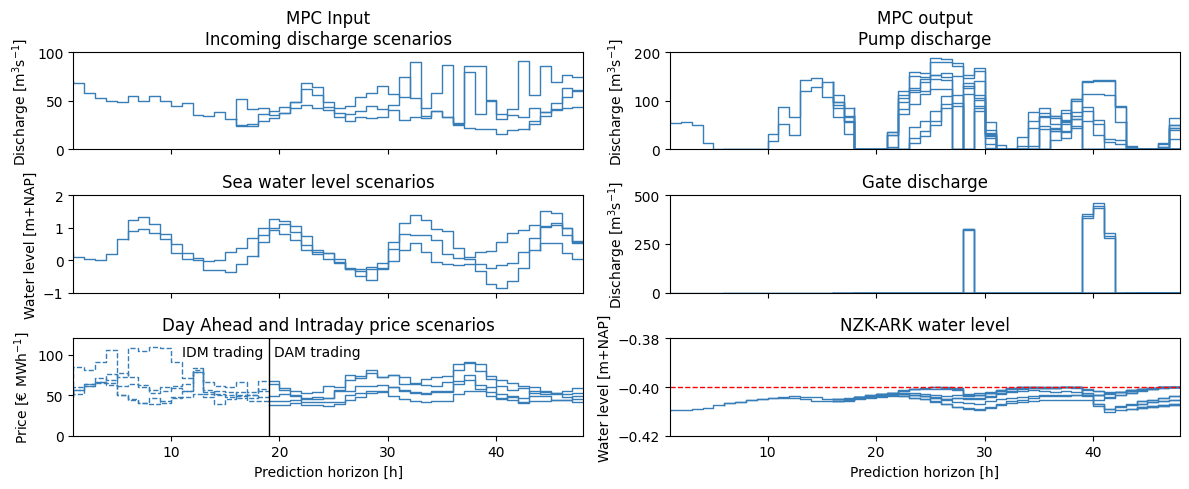

In [17]:
fig, ax = plot_results(results, problem, data_dict, 'pre') # CVAR 0.9

In [18]:
def make_opt_settings(cvar_wl, cvar_alpha, h_max, n_scenarios, constraint_type='cvar', tree=False, obs=False):
    if obs:
        dist='obs'
    else:
        dist='energy'
    optimization_settings = {
        'wl_constraint_type': constraint_type,
        'var_wl': -0.4,
        'cvar_wl': cvar_wl,
        'cvar_alpha': cvar_alpha,
        'p_chance': 1,
        'h_max': h_max,
        'obj_type': 'expected_value',
        'refit_idm_bn_every': 7*24, # every week
        'start_wl': -0.41, # m+NAP
        'distance': dist,
        'n_scenarios': n_scenarios,
        'tree': tree
    }
    if optimization_settings['tree']:
        tree_classes = ['discharge', 'wl']
    else:
        tree_classes = []
    return optimization_settings, tree_classes

In [19]:
exp_name = 'plotting'
optimization_datapath_exp = None

year = 2019
month = 1

t_now = obs_data.dam.loc[(obs_data.dam.index.year==year) & (obs_data.dam.index.month==month)].index.min() + pd.DateOffset(hours=11)
t_now = t_now + pd.DateOffset(days=16) - pd.DateOffset(hours=6)
simulation_index = pd.date_range(t_now, t_now + pd.DateOffset(days=7), freq='H')
t_now

Timestamp('2019-01-17 05:00:00+0100', tz='Europe/Amsterdam')

In [20]:
def run_optimization(t_now, optimization_settings, tree_classes, exp_name, optimization_datapath_exp, data_dict=None):
    simulator = ClosedLoopSimulation(
        savepath=optimization_datapath / exp_name,
        optimization_settings=optimization_settings,
        simulation_index=simulation_index,
        observation_dataclass=obs_data,
        scenario_dataclass=scenario_data,
        idm_scenarioclass=idm_scenarios,
        save_individual_timesteps=True,
        simulation_data=None,
        tree_classes=tree_classes,
    )

    if data_dict is None:
        data_dict = simulator.prep_opt_data(t_now, inplace=True, return_data=True)
    
    problem = NZKProblem(
        optimization_data=data_dict,
        optimization_settings=optimization_settings,
        tree_classes=tree_classes,
        pred_hor=48,
        logfile=str((simulator.savepath_timesteps / f'{t_now.strftime("%Y-%m-%d")}.log').resolve())
    )
    problem.make_model()
    model = problem.solve(verbose=False)
    results = problem.get_results()
    return results, problem, data_dict

In [21]:
result_dict = {}
problem_dict = {}

In [22]:
data_dict = None
n_scenarios = 5

# CVaR variations
for h_max in[-0.4]:
    result_dict[h_max] = {}
    problem_dict[h_max] = {}
    for cvar_wl in [-0.3, -0.395]:
        result_dict[h_max][cvar_wl] = {}
        problem_dict[h_max][cvar_wl] = {}
        for cvar_alpha in [0.8, 0.9, 0.99]:
            print(f'Running h_max={h_max}, cvar_wl={cvar_wl}, cvar_alpha={cvar_alpha}')
            try:
                done = result_dict[h_max][cvar_wl][cvar_alpha]
            except KeyError:
                done = False
            
            if done:
                print('Already done')
                continue
            optimization_settings, tree_classes = make_opt_settings(constraint_type='cvar', cvar_wl=cvar_wl, cvar_alpha=cvar_alpha, h_max=h_max, n_scenarios=n_scenarios, tree=False, obs=False)
            results, problem, data_dict = run_optimization(t_now, optimization_settings, tree_classes, exp_name, optimization_datapath_exp, data_dict=data_dict)
            result_dict[h_max][cvar_wl][cvar_alpha] = results
            problem_dict[h_max][cvar_wl][cvar_alpha] = problem

# Robust
print(f'Running robust')
optimization_settings, tree_classes = make_opt_settings(constraint_type='robust', cvar_wl=-0.4, cvar_alpha=1, h_max=-0.4, n_scenarios=n_scenarios, tree=False, obs=False)
results, problem, data_dict = run_optimization(t_now, optimization_settings, tree_classes, exp_name, optimization_datapath_exp, data_dict=data_dict)
result_dict['robust'] = results
problem_dict['robust'] = problem


Running h_max=-0.4, cvar_wl=-0.3, cvar_alpha=0.8
Running h_max=-0.4, cvar_wl=-0.3, cvar_alpha=0.9
    containing a solution
Running h_max=-0.4, cvar_wl=-0.3, cvar_alpha=0.99
    containing a solution
Running h_max=-0.4, cvar_wl=-0.395, cvar_alpha=0.8
    containing a solution
Running h_max=-0.4, cvar_wl=-0.395, cvar_alpha=0.9
Running h_max=-0.4, cvar_wl=-0.395, cvar_alpha=0.99
Running robust


In [23]:
# with open(optimization_datapath / 'plotting' / 'results.pkl', 'wb') as f:
#     pickle.dump(result_dict, f)

# with open(optimization_datapath / 'plotting' / 'problems.pkl', 'wb') as f:
#     pickle.dump(problem_dict, f)

# with open(optimization_datapath / 'plotting' / 'data.pkl', 'wb') as f:
#     pickle.dump(data_dict, f)
    

In [24]:
# with open(optimization_datapath / 'plotting' / 'results.pkl', 'rb') as f:
#     result_dict = pickle.load(f)

# with open(optimization_datapath / 'plotting' / 'problems.pkl', 'rb') as f:
#     problem_dict = pickle.load(f)

# with open(optimization_datapath / 'plotting' / 'data.pkl', 'rb') as f:
#     data_dict = pickle.load(f)

In [27]:
def plot_mpc_inputs(problem, data_dict, ax, col=0, where='pre'):
    # Inputs on the left
    
    ax_ = ax[0]
    while True:
        try:    
            plot_nodesedges(ax_, problem.nodes_edges_discharge, cb_colorlist[0], where=where)
            ylims = (0, np.ceil(ax_.get_ylim()[1]/10)*10)
            ax_.set_ylim(ylims)
            ax_.set_title('Incoming discharge scenarios')
            ax_.set_ylabel('Discharge [m$^{3}$ s$^{-1}$]')
            break
        except:
            ax_ = ax[0,col]

    ax_ = ax[1]
    while True:
        try:
            plot_nodesedges(ax_, problem.nodes_edges_wl, cb_colorlist[0], where=where)
            ylims = (np.floor(ax_.get_ylim()[0]/1)*1, np.ceil(ax_.get_ylim()[1]/1)*1)
            ax_.set_ylim(ylims)
            ax_.set_title('Sea water level scenarios')
            ax_.set_ylabel('Water level [m+NAP]')
            break
        except:
            ax_ = ax[1,col]

    ax_ = ax[2]
    while True:
        try:
            # IDM prices
            idm_trading_indices = [t for t in data_dict['E_dam'].keys() if not np.isnan(data_dict['E_dam'][t])]
            for i in range(len(data_dict['idm'][idm_trading_indices[0]])):
                ax_.step(idm_trading_indices, [data_dict['idm'][t][i] for t in idm_trading_indices], color=cb_colorlist[0], linestyle='--', linewidth=1, where=where)

            # DAM prices
            dam_trading_indices = [t for t in data_dict['E_dam'].keys() if np.isnan(data_dict['E_dam'][t])]
            dam_trading_indices = [min(dam_trading_indices) - 1] + dam_trading_indices
            for i in range(len(data_dict['dam'][dam_trading_indices[1]])):
                ax_.step(dam_trading_indices, [data_dict['dam'][dam_trading_indices[0]]] + [data_dict['dam'][t][i] for t in dam_trading_indices[1:]], color=cb_colorlist[0], linewidth=1, where=where)

            ax_.axvline(x=dam_trading_indices[0], color='black', linewidth=1)
            textheight = ax_.get_ylim()[1] - 10
            ax_.text(dam_trading_indices[0] + 0.5, textheight, 'DAM trading', verticalalignment='center', horizontalalignment='left')
            ax_.text(dam_trading_indices[0] - 0.5, textheight, 'IDM trading', verticalalignment='center', horizontalalignment='right')
            ylims = (0, np.ceil(ax_.get_ylim()[1]/10)*10)
            ax_.set_ylim(ylims)

            ax_.set_title('Day Ahead and Intraday price scenarios')
            ax_.set_ylabel('Price [€ MWh$^{-1}$]')
            ax_.set_xlabel('Prediction horizon [h]')
            break
        except:
            ax_ = ax[2,col]

def plot_single_mpc_outputs(results, problem, ax, var, where='pre'):
    # Outputs on the right
    if var=='q_pump':
        plot_res(ax, 'q_pump', results, cb_colorlist[0], where=where)
        ylims = (0, np.ceil(ax.get_ylim()[1]/10)*10)
        ax.set_ylim(ylims)
        # ax.set_title('Pump discharge - MPC output')
        ax.set_ylabel('Discharge [m$^{3}$ s$^{-1}$]')
    elif var=='q_gate':
        plot_res(ax, 'q_gate', results, cb_colorlist[0], where=where)
        ylims = (0, 500)
        ax.set_ylim(ylims)
        ax.set_yticks([0, 250, 500])
        # ax[1,1].set_title('Gate discharge - MPC output')
        ax.set_ylabel('Discharge [m$^{3}$ s$^{-1}$]')
    elif var=='h_nzk':
        plot_res(ax, 'h_nzk', results, cb_colorlist[0], where=where)
        ax.axhline(y=-0.4, color='red', linewidth=1, ls='--')

        ax.set_ylim(-0.42, -0.36)
        # ax[2,1].set_title('NZK-ARK water level - MPC output')
        ax.set_ylabel('Water level [m+NAP]')
        # ax[2,1].set_ylim(-0.5, -0.35)
        ax.set_xlabel('Prediction horizon [h]')

def plot_comparison(problem_dict, result_dict, data_dict):
    fig, ax = plt.subplots(4, 3, figsize=(15, 8), sharex=True)

    # Plot the inputs on the left
    problem = problem_dict['robust']
    plot_mpc_inputs(problem, data_dict, ax, col=0)
    ax[0,2].set_xlabel('')

    # Plot the robust waterlevel under the inputs
    results = result_dict['robust']
    plot_single_mpc_outputs(results, problem, ax[3,0], 'h_nzk')
    ax[3,0].set_title(f'Robust MPC output')
    ax[3,0].set_xlabel('Prediction horizon [h]')

    # Plot the waterlevels in the resulting axes
    for h_max in [-0.4, -0.3]:
        if h_max == -0.4:
            col=1
        elif h_max == -0.3:
            col=2
        
        row=0
        for cvar_wl in [-0.395, -0.3]:
            for cvar_alpha in [0.9, 0.8]:
                problem = problem_dict[h_max][cvar_wl][cvar_alpha]
                results = result_dict[h_max][cvar_wl][cvar_alpha]
                plot_single_mpc_outputs(results, problem, ax[row, col], 'h_nzk')
                title = 'CVaR$_{'+str(cvar_alpha)+'}$'
                title += f'$\leq${cvar_wl}, h_max={h_max}'
                ax[row, col].set_title(title)
                if row!=3:
                    # Remove xlabel
                    ax[row, col].set_xlabel('')
                
                if col==2:
                    # Remove yticks and label
                    ax[row, col].set_yticks([])
                    ax[row, col].set_ylabel('')
                row+=1

    for ax_ in ax.flatten():
        ax_.set_xlim(1,48)

    # Redivide the width after removing the yticks
    fig.subplots_adjust(wspace=0.1)
    
    fig.tight_layout()
    return fig, ax

In [32]:
def plot_input_and_wl(problem_dict, result_dict, data_dict):
    fig, ax = plt.subplots(4, 1, figsize=(5, 8), sharex=True)

    # Plot the inputs on the left
    problem = problem_dict['robust']
    plot_mpc_inputs(problem, data_dict, ax, col=0)
    ax[2].set_xlabel('')

    # Plot the robust waterlevel under the inputs
    results = result_dict['robust']
    plot_single_mpc_outputs(results, problem, ax[3], 'h_nzk')
    ax[3].set_title(f'Robust MPC output')
    ax[3].set_xlabel('Prediction horizon [h]')

    for ax_ in ax.flatten():
        ax_.set_xlim(1,48)

    return fig, ax

def plot_wls(problem_dict, result_dict, data_dict):
    fig, ax = plt.subplots(3, 2, figsize=(12,5), sharex=True, sharey=True)
    # Plot the waterlevels in the resulting axes
    for h_max in [-0.4]:
        # if h_max == -0.4:
        #     col=0
        # elif h_max == -0.3:
        #     col=1
        
        
        for cvar_wl in [-0.395, -0.3]:
            if cvar_wl == -0.395:
                col=0
            elif cvar_wl == -0.3:
                col=1
            row=0
            for cvar_alpha in [0.99, 0.9, 0.8]:
                problem = problem_dict[h_max][cvar_wl][cvar_alpha]
                results = result_dict[h_max][cvar_wl][cvar_alpha]
                plot_single_mpc_outputs(results, problem, ax[row, col], 'h_nzk')
                title = r'$\alpha$='+f'{cvar_alpha}'#'CVaR$_{'+str(cvar_alpha)+'}$'
                title += r'$\quad \gamma$='+f'{cvar_wl} m+NAP'#, h_max={h_max}'
                ax[row, col].set_title(title)
                if row!=2:
                    # Remove xlabel
                    ax[row, col].set_xlabel('')

                if row != 1:
                    ax[row, col].set_ylabel('')
                
                if col==1:
                #     # Remove yticks and label
                #     ax[row, col].set_yticks([])
                    ax[row, col].set_ylabel('')
                # ax[row,col].set_yticks([-0.42, -0.4, -0.38])
                ax[row,col].set_ylim(-0.42, -0.38)
                row+=1

    for ax_ in ax.flatten():
        ax_.set_xlim(1,48)

    # Redivide the width after removing the yticks
    fig.subplots_adjust(wspace=0.1)
    fig.tight_layout()

    return fig, ax


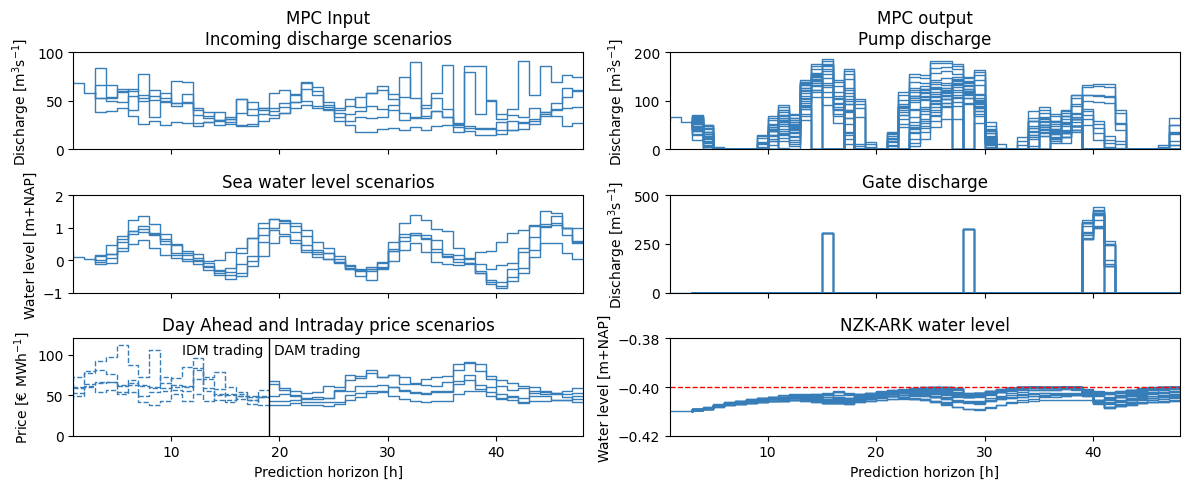

In [29]:
fig, ax = plot_results(result_dict['robust'], problem_dict['robust'], data_dict, 'pre') # CVAR 0.9
plt.savefig(optimization_datapath / 'plotting' / 'robust.pdf', dpi=300, bbox_inches='tight')

In [33]:
# fig, ax = plot_input_and_wl(problem_dict, result_dict, data_dict)

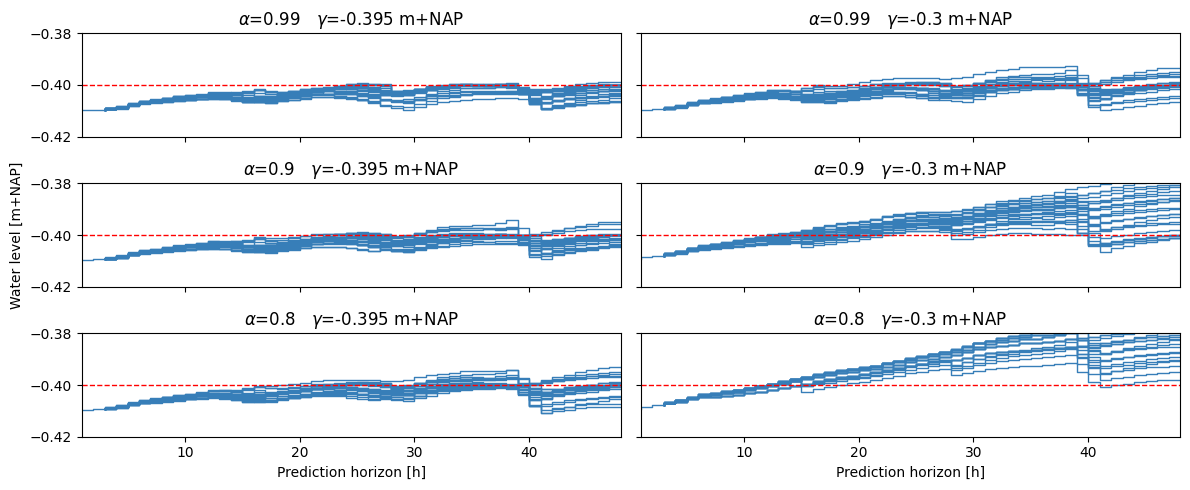

In [34]:
fig, ax = plot_wls(problem_dict, result_dict, data_dict)
plt.savefig(optimization_datapath / 'plotting' / 'cvar_waterlevels.pdf', dpi=300, bbox_inches='tight')


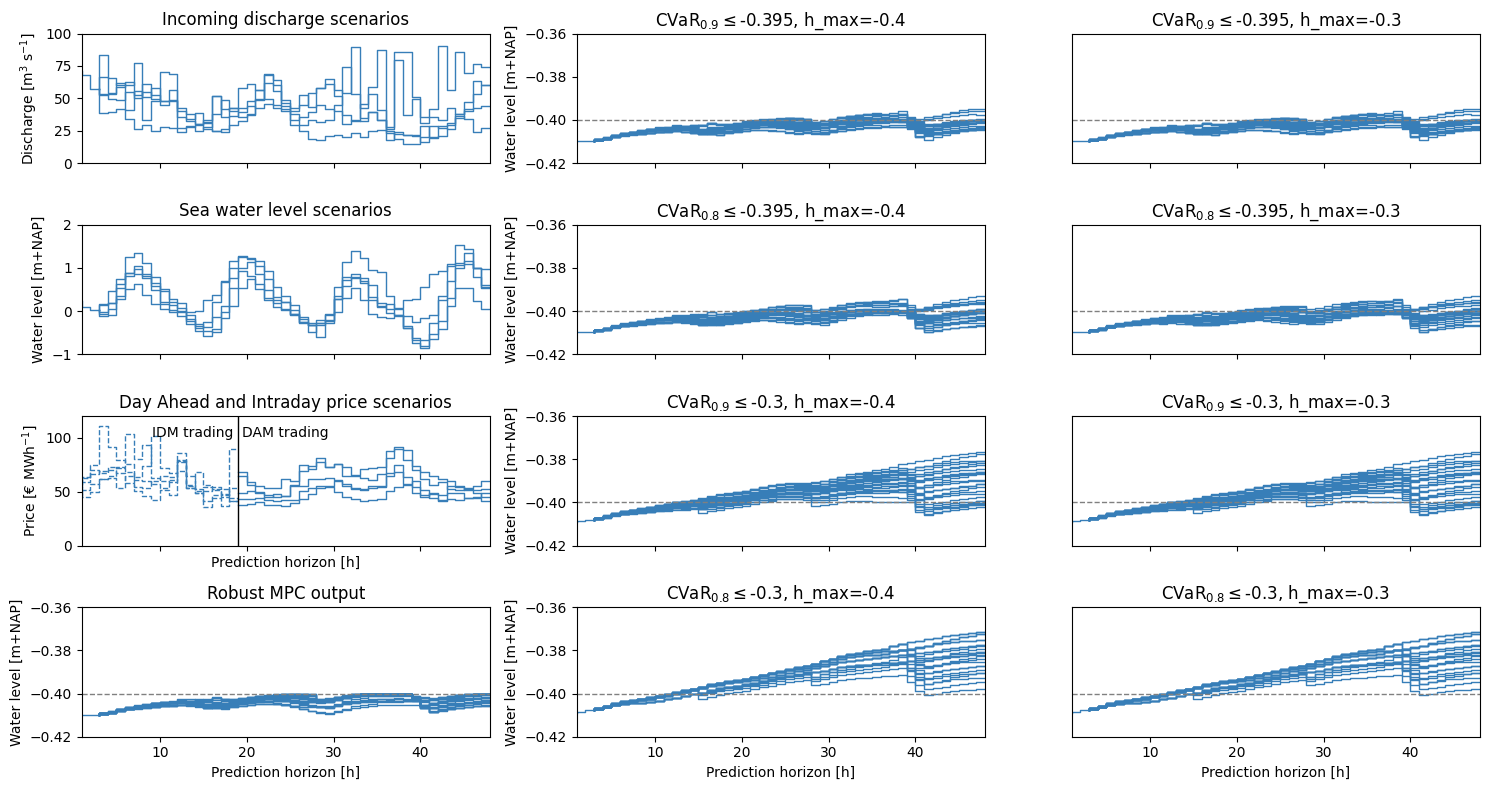

In [69]:
fig, ax = plot_comparison(problem_dict, result_dict, data_dict)

In [ ]:

simulator = ClosedLoopSimulation(
    savepath=optimization_datapath / exp_name,
    optimization_settings=optimization_settings,
    simulation_index=simulation_index,
    observation_dataclass=obs_data,
    scenario_dataclass=scenario_data,
    idm_scenarioclass=idm_scenarios,
    save_individual_timesteps=True,
    simulation_data=None,
    tree_classes=tree_classes,
)
data_dict = simulator.prep_opt_data(t_now, inplace=True, return_data=True)
problem = NZKProblem(
    optimization_data=data_dict,
    optimization_settings=optimization_settings,
    tree_classes=tree_classes,
    pred_hor=48,
    logfile=str((simulator.savepath_timesteps / f'{t_now.strftime("%Y-%m-%d")}.log').resolve())
)
problem.make_model()
model = problem.solve(verbose=True)
results = problem.get_results()

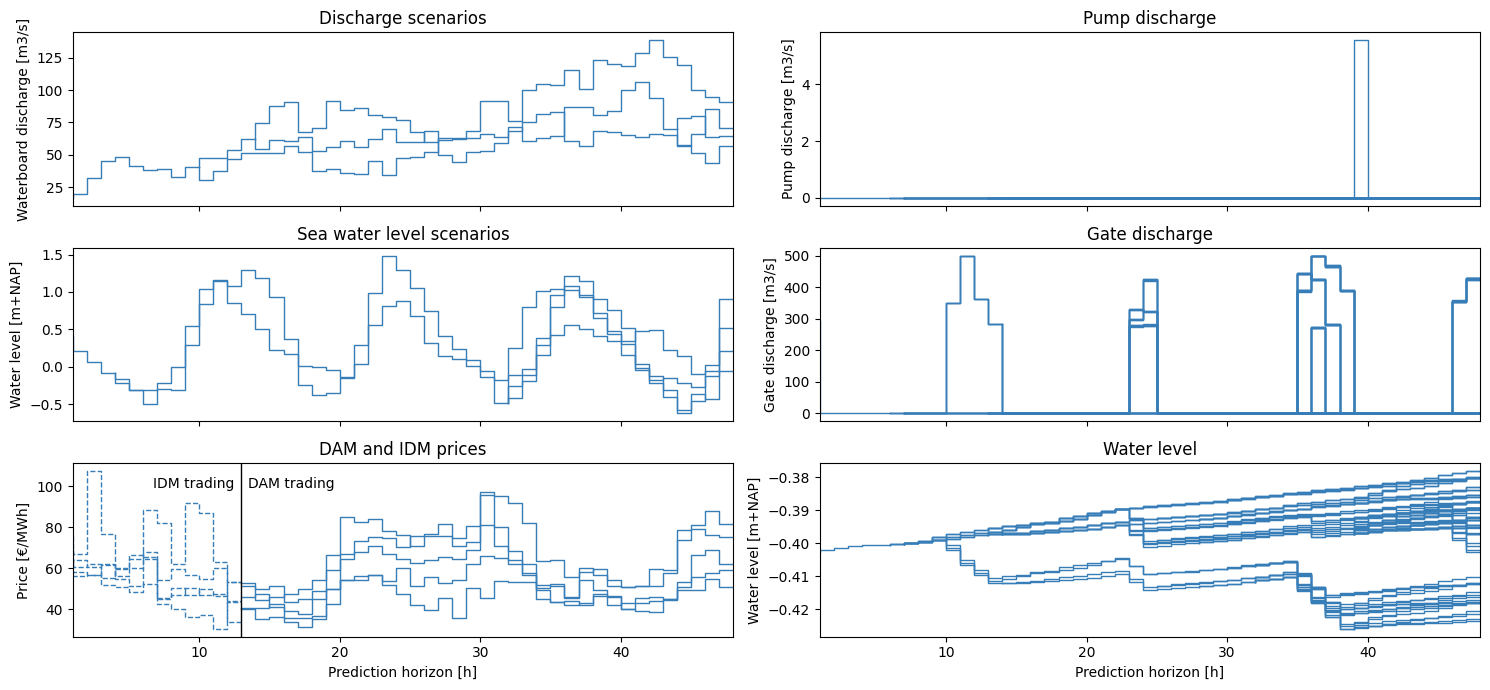

In [103]:
fig, ax = plot_results(results, problem, data_dict, 'pre') # CVAR 0.9